In [267]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import soundfile as sf
import seaborn as sns
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset

from pytube import YouTube
from pydub import AudioSegment
from pytube.innertube import InnerTube
import subprocess

SR = 16000 # Sufficient to perceive the frequency range of human voices
HOP_LENGTH = 512
NFFT = 2048

# DATA COLLECTION 
To collect quality data for each language, videos with a "Creative Commons" license were watched on YouTube. The URLs of the videos, which totaled approximately 6 hours, were saved in csv files. Data Collection codes were written to download these URLs as wav files and create 13-second segments. This data will be combined with OpenSLR data and converted to a spectrogram and then used in model training.

In [71]:
def youtube_to_wav(youtube_url, output_path="output.wav"):
    command = [
        "yt-dlp",
        "--extract-audio",
        "--audio-format", "wav",
        "--audio-quality", "0",  # Highest quality (0 is best)
        "--output", output_path,
        youtube_url,
    ]
    
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e.stderr}")
        print(f"Command output: {e.stdout}")

In [72]:
# Saves wav files to respective directory and adds "filename" column to dataframe
def save_data(df, out_dir):
    i = 0
    filenames = []
    for url in df['url']:
        filename = f"{i}.wav"
        out_path = out_dir + f"/{filename}"

        youtube_to_wav(url, output_path=out_path)

        filenames.append(filename)
        
        i+=1

    filenames = pd.Series(filenames)
    df["filename"] = filenames

    return df

## Read csv files and download the wav files from urls

In [73]:
df_tr = pd.read_csv("../urls/tr.csv")
df_tr.head()

start    end                                          url
0   0.10   7.57  https://www.youtube.com/watch?v=ihrIL2qQbgs
1   0.00  17.22  https://www.youtube.com/watch?v=GAz-K_iFfM8
2   0.13    NaN  https://www.youtube.com/watch?v=Nm3g8PokIp0
3   0.03   1.55  https://www.youtube.com/watch?v=N5I5NDkNPRc
4   0.03   1.00  https://www.youtube.com/watch?v=SsvdgkeNePw

In [74]:
df_tr = save_data(df_tr, "../data/collected/tr_new")
df_tr.head()

start    end                                          url filename
0   0.10   7.57  https://www.youtube.com/watch?v=ihrIL2qQbgs    0.wav
1   0.00  17.22  https://www.youtube.com/watch?v=GAz-K_iFfM8    1.wav
2   0.13    NaN  https://www.youtube.com/watch?v=Nm3g8PokIp0    2.wav
3   0.03   1.55  https://www.youtube.com/watch?v=N5I5NDkNPRc    3.wav
4   0.03   1.00  https://www.youtube.com/watch?v=SsvdgkeNePw    4.wav

In [75]:
df_es = pd.read_csv("../urls/es.csv")
df_es.head()

start    end                                          url
0   0.05   3.30  https://www.youtube.com/watch?v=GoUOny9HoSE
1   0.05   3.35  https://www.youtube.com/watch?v=bCtFIM80oJE
2   0.07  21.52  https://www.youtube.com/watch?v=cytY3YH1f2I
3   0.10  16.25  https://www.youtube.com/watch?v=MrPEnikb2Rk
4   0.02   2.48  https://www.youtube.com/watch?v=7KAan82-uEk

In [76]:
df_es = save_data(df_es, "../data/collected/es_new")
df_es.head()

start    end                                          url filename
0   0.05   3.30  https://www.youtube.com/watch?v=GoUOny9HoSE    0.wav
1   0.05   3.35  https://www.youtube.com/watch?v=bCtFIM80oJE    1.wav
2   0.07  21.52  https://www.youtube.com/watch?v=cytY3YH1f2I    2.wav
3   0.10  16.25  https://www.youtube.com/watch?v=MrPEnikb2Rk    3.wav
4   0.02   2.48  https://www.youtube.com/watch?v=7KAan82-uEk    4.wav

In [77]:
df_fr = pd.read_csv("../urls/fr.csv")
df_fr.head()

start    end                                          url
0   0.06   3.20  https://www.youtube.com/watch?v=QwnADXL9yk8
1   0.00   0.45  https://www.youtube.com/watch?v=PO5vtZMw7SY
2   0.05  10.15  https://www.youtube.com/watch?v=HhljUdMUbs0
3   0.16   4.00  https://www.youtube.com/watch?v=qxmX6Jp5Mk0
4   0.10   2.44  https://www.youtube.com/watch?v=ga-j8zSAXH4

In [78]:
df_fr = save_data(df_fr, "../data/collected/fr_new")
df_fr.head()

start    end                                          url filename
0   0.06   3.20  https://www.youtube.com/watch?v=QwnADXL9yk8    0.wav
1   0.00   0.45  https://www.youtube.com/watch?v=PO5vtZMw7SY    1.wav
2   0.05  10.15  https://www.youtube.com/watch?v=HhljUdMUbs0    2.wav
3   0.16   4.00  https://www.youtube.com/watch?v=qxmX6Jp5Mk0    3.wav
4   0.10   2.44  https://www.youtube.com/watch?v=ga-j8zSAXH4    4.wav

In [79]:
df_ar = pd.read_csv("../urls/ar.csv")
df_ar.head()

start   end                                          url
0   0.00  7.03  https://www.youtube.com/watch?v=ckcbx_BeJtY
1   0.00  5.59  https://www.youtube.com/watch?v=2L-Szfp4hxI
2   0.00  1.05  https://www.youtube.com/watch?v=ISC14UkFA6E
3   0.05  5.55  https://www.youtube.com/watch?v=XDxVS-WgFsE
4   0.06  3.01  https://www.youtube.com/watch?v=3seRFWdXe0o

In [80]:
df_ar = save_data(df_ar, "../data/collected/ar_new")
df_ar.head()

start   end                                          url filename
0   0.00  7.03  https://www.youtube.com/watch?v=ckcbx_BeJtY    0.wav
1   0.00  5.59  https://www.youtube.com/watch?v=2L-Szfp4hxI    1.wav
2   0.00  1.05  https://www.youtube.com/watch?v=ISC14UkFA6E    2.wav
3   0.05  5.55  https://www.youtube.com/watch?v=XDxVS-WgFsE    3.wav
4   0.06  3.01  https://www.youtube.com/watch?v=3seRFWdXe0o    4.wav

In [179]:
# To convert minutes to seconds when clipping audio
def min_to_sec(value):
    if pd.isna(value):
        return pd.NA
    
    minutes = int(value)
    seconds = value - minutes
    total_seconds = minutes * 60 + seconds

    return int(total_seconds)

## Clip only the talking parts of audios

In [82]:
def clip_wav(df, data_dir):
    clips = []
    for index,row in df.iterrows():
        path = data_dir + f"/{row['filename']}"
        
        start = row["start"] # e.g. 0.05 (needs to be converted to seconds)
        end = row["end"] # e.g. 2.35 (needs to be converted to seconds)

        start = min_to_sec(start)
        end = min_to_sec(end)

        y, sr = librosa.load(path, sr=SR)
    
        start*= sr
        end*= sr

        if pd.isna(end):
            clip = y[start:]
        else:
            clip = y[start:end]
        
        clips.append(clip)

    return clips 

In [83]:
ar_list = clip_wav(df_ar, "../data/collected/ar_new")
es_list = clip_wav(df_es, "../data/collected/es_new")
fr_list = clip_wav(df_fr, "../data/collected/fr_new")
tr_list = clip_wav(df_tr, "../data/collected/tr_new")

In [176]:
def spec_show(y, sr, title):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH, n_fft=NFFT)

    plt.figure(figsize=(10, 4))

    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    print(db_spec.shape)
    librosa.display.specshow(db_spec, sr=sr, x_axis='time', y_axis='mel')

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spektrogram - {title}')
    plt.tight_layout()
    plt.show()

# Sample Spectrograms (Collected Data)

(128, 13126)


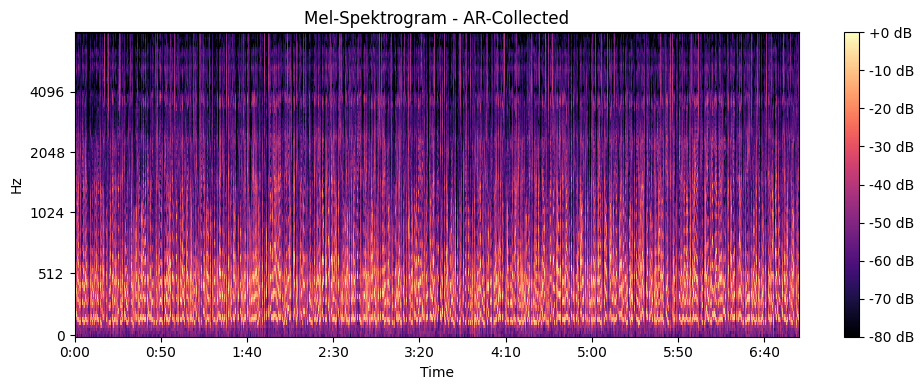

(128, 5626)


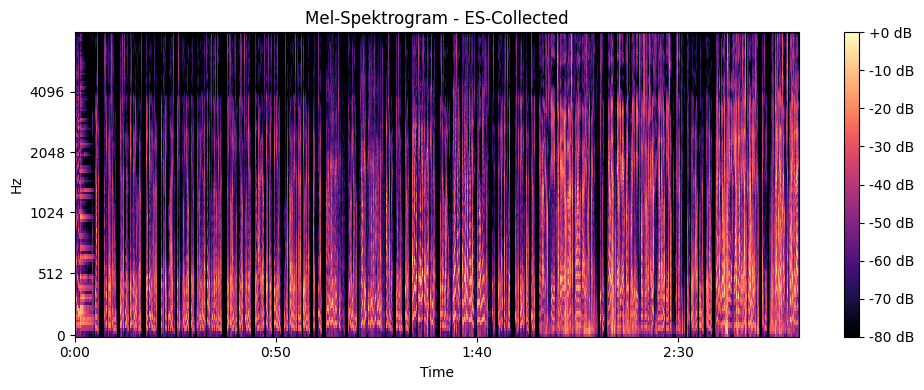

(128, 5626)


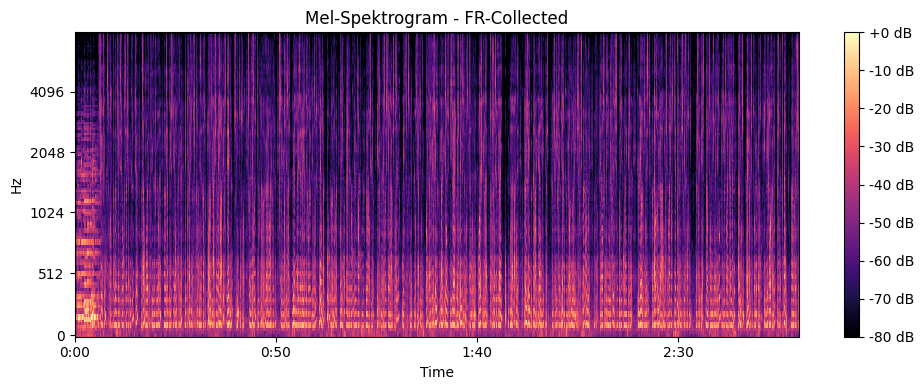

(128, 13126)


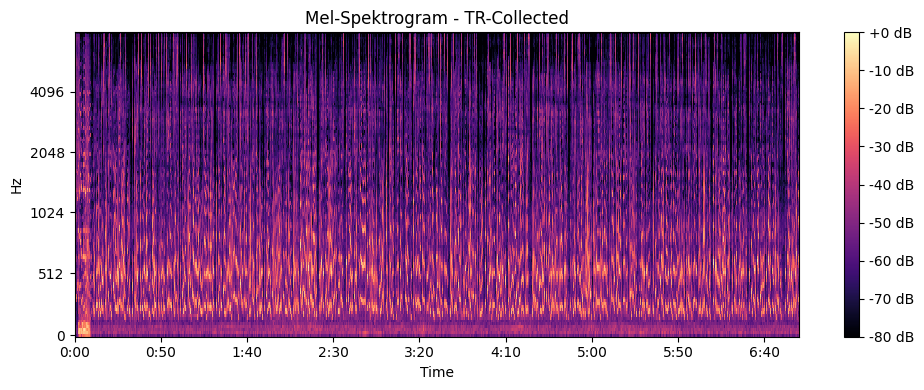

In [177]:
spec_show(ar_list[0], SR, "AR-Collected")
spec_show(es_list[0], SR, "ES-Collected")
spec_show(fr_list[0], SR, "FR-Collected")
spec_show(tr_list[0], SR, "TR-Collected")

## Split data into 13-second segments

In [86]:
def segment_data(array_list, label, duration=13):
    segmented_list = [] 
    labels = []

    for array in array_list:
        array_length = len(array)
        start = 0
        end = SR * duration
        
        while array_length - end >= 13*SR:
            segment = array[start:end]
            segmented_list.append(segment)
            labels.append(label)

            start += 13*SR
            end += 13*SR
    
    segmented_arr = np.array(segmented_list)
    labels_arr = np.array(labels)

    return segmented_arr, labels_arr

In [87]:
ar_segmented, ar_labels = segment_data(ar_list, 0)
es_segmented, es_labels = segment_data(es_list, 1)
fr_segmented, fr_labels = segment_data(fr_list, 2)
tr_segmented, tr_labels = segment_data(tr_list, 3)

In [88]:
ar_segmented.shape, es_segmented.shape, fr_segmented.shape, tr_segmented.shape

((329, 208000), (321, 208000), (322, 208000), (336, 208000))

**Number of collected datapoints(13 seconds) per class**\
Arabic: 329  -  Spanish: 321  -  French: 322  -  Turkish: 336 || Total: 1308

## Sample 13-second spectrograms 

(128, 407)


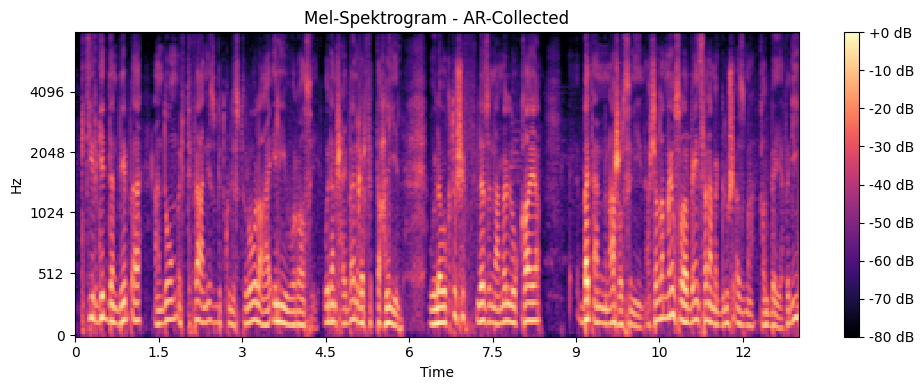

(128, 407)


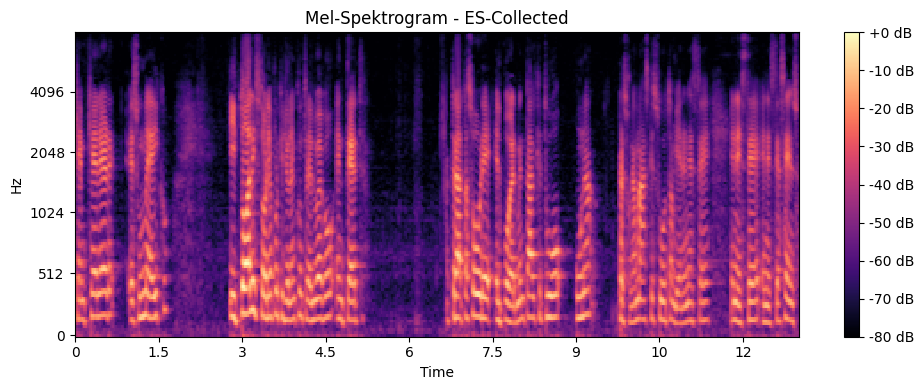

(128, 407)


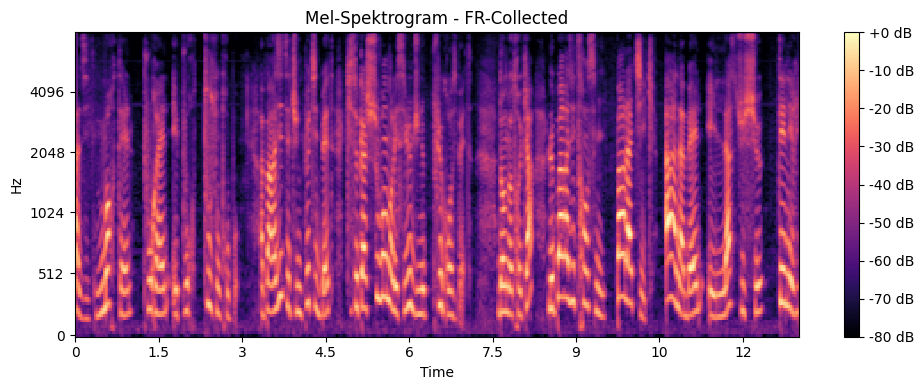

(128, 407)


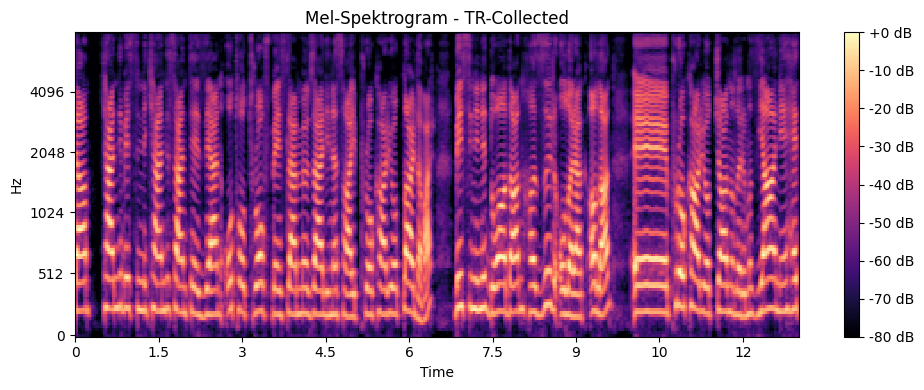

In [178]:
spec_show(ar_segmented[100], SR, "AR-Collected")
spec_show(es_segmented[100], SR, "ES-Collected")
spec_show(fr_segmented[100], SR, "FR-Collected")
spec_show(tr_segmented[100], SR, "TR-Collected")

# OPENSLR DATASET

In [91]:
DATA_DIR = "../data/openslr"
AR_DIR = DATA_DIR + "/AR"
ES_DIR = DATA_DIR + "/ES"
FR_DIR = DATA_DIR + "/FR"
TR_DIR = DATA_DIR + "/TR"

In [92]:
filename_AR = "/0a0d1abd-0bd3-45f8-818f-8ab214be329e.flac"
filename_ES = "/0a530b75-d3b1-4533-8ca9-f405d41b445e.flac"
filename_FR = "/00c2529e-9705-464e-bbc2-acbe19916095.flac"
filename_TR = "/00a38ecc-2a37-4c3f-803b-607031004e4f.flac"

file_path_AR = AR_DIR + filename_AR
file_path_ES = ES_DIR + filename_ES
file_path_FR = FR_DIR + filename_FR
file_path_TR = TR_DIR + filename_TR

In [93]:
# def mel_to_audio(db_spec, sr):
#     # Mel-spektrogramı geri mel amplitüdüne çevir
#     S = librosa.db_to_power(db_spec)

#     y_inv = librosa.feature.inverse.mel_to_audio(S, sr=sr, hop_length=HOP_LENGTH, n_fft=NFFT)

#     sf.write('geri.wav', y_inv, sr)
#     return y_inv

# Sample Spectrograms (OpenSLR Data)

AR
(128, 466)


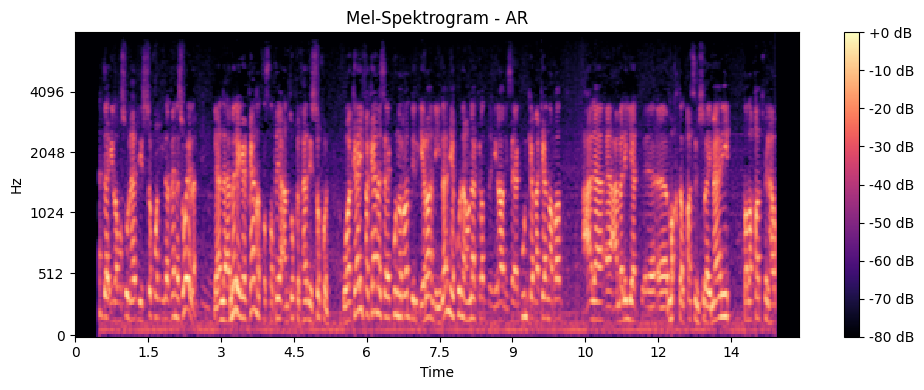

(128, 451)


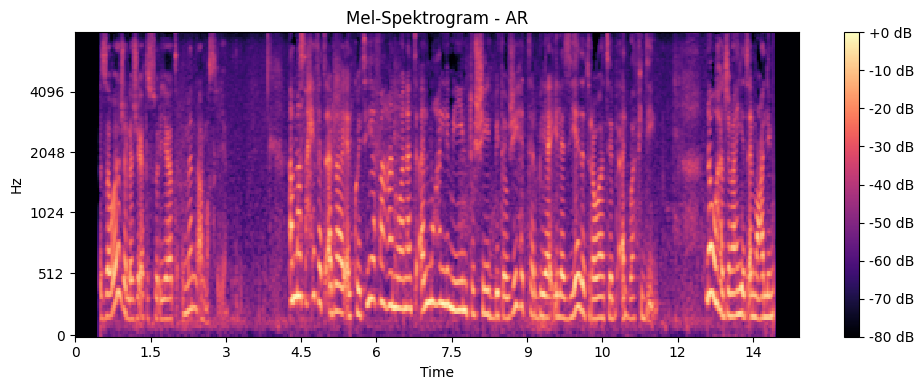

(128, 419)


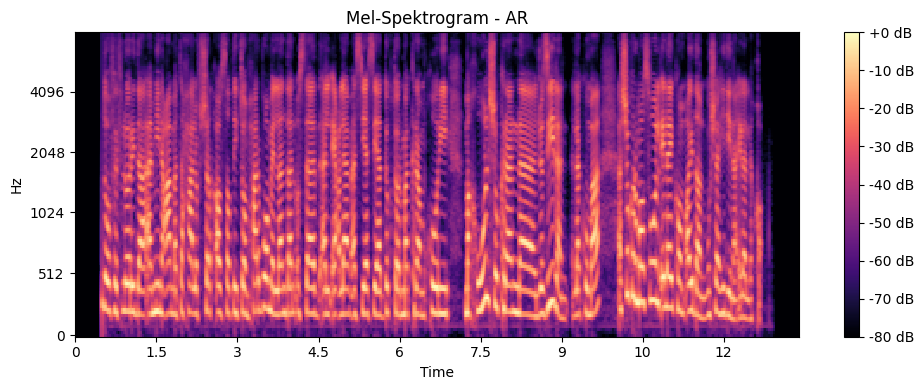

ES
(128, 466)


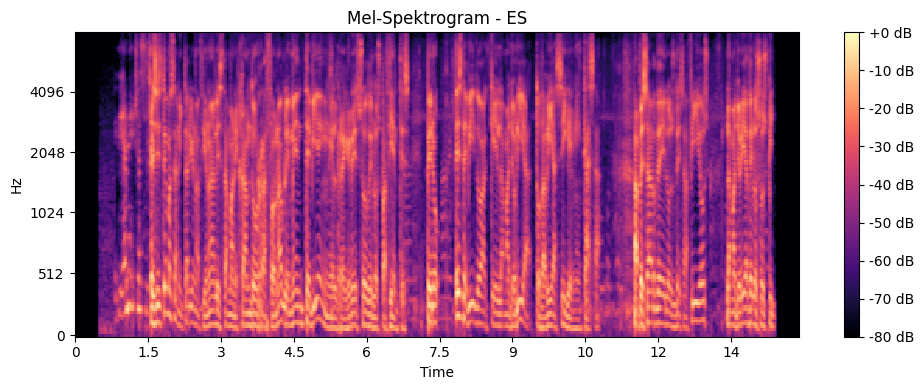

(128, 460)


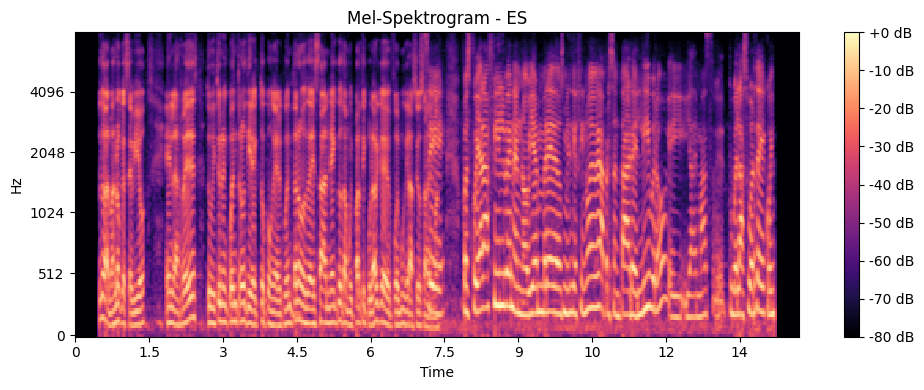

(128, 229)


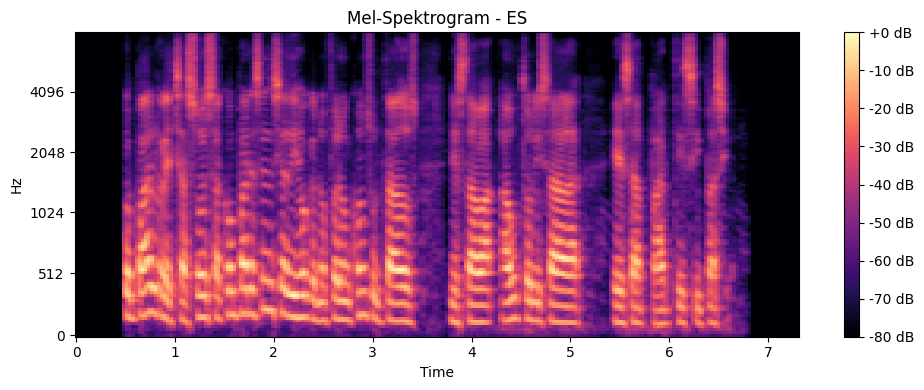

FR
(128, 463)


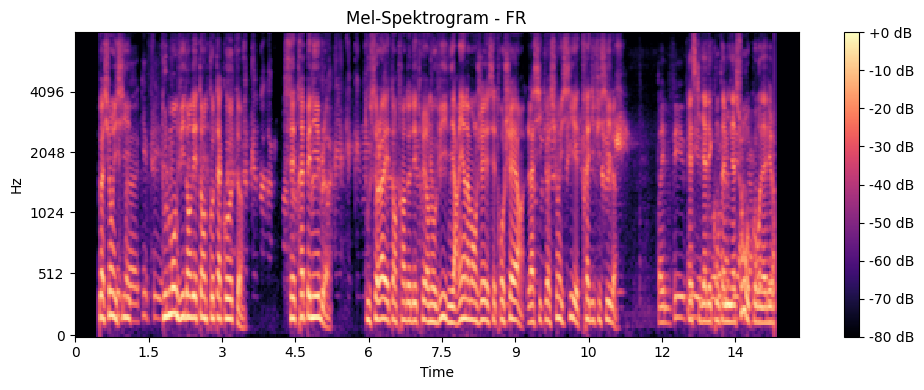

(128, 413)


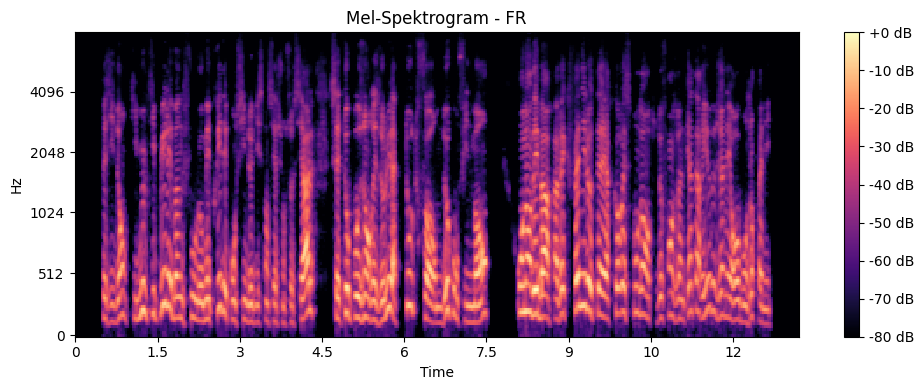

(128, 451)


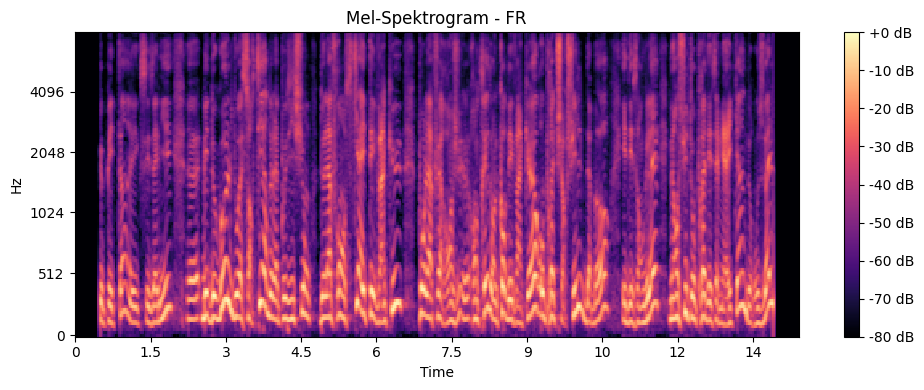

TR
(128, 454)


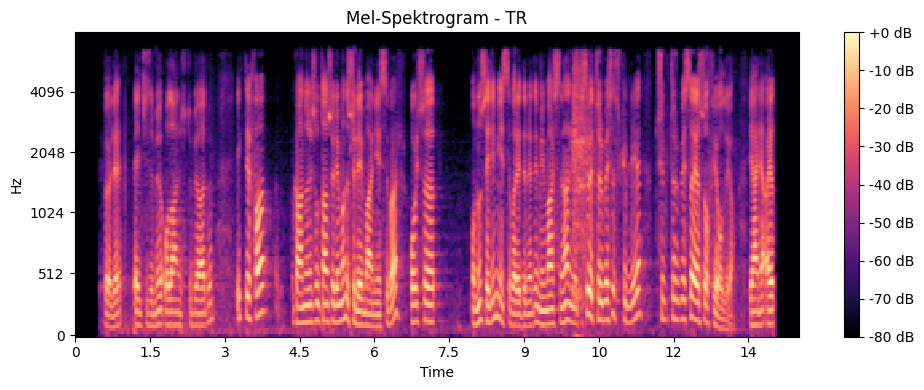

(128, 457)


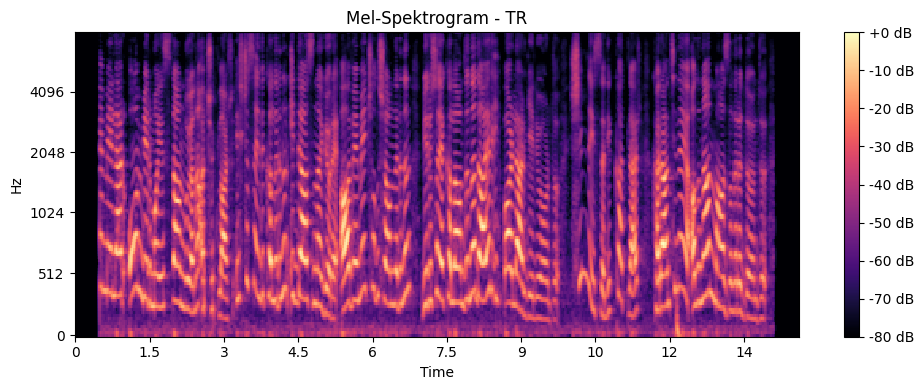

(128, 463)


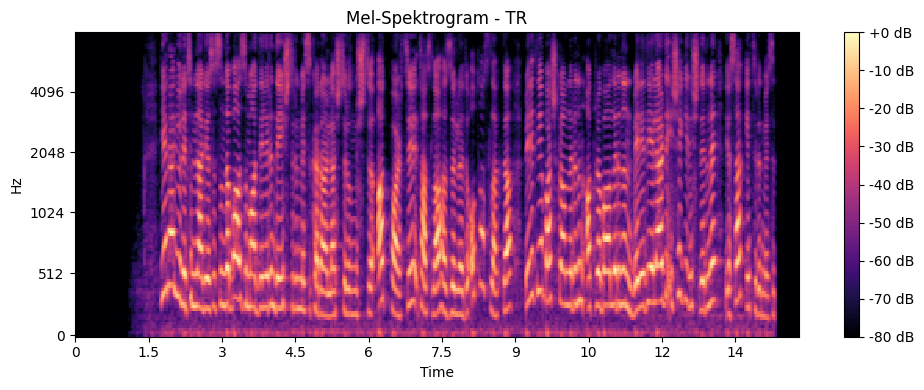

Minimum Length (seconds): 3.4
Maximum Length (seconds): 14.9
Total files shorter than 13 seconds: 572
Total files: 10022


In [94]:
min_len = np.inf
max_len = 0
short_files = 0
total_files = 0
for folder_name in os.listdir(DATA_DIR):
    print(folder_name)
    folder_path = os.path.join(DATA_DIR, folder_name)
    i = 0
    for filename in os.listdir(folder_path):
    
        if filename.endswith("txt"):
            continue
        
        total_files += 1

        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=None)

        if len(y) < min_len:
            min_len = len(y)
        
        if len(y) > max_len:
            max_len = len(y)

        if len(y) / sr < 13:
            short_files += 1

        if i < 3:
            spec_show(y,sr,folder_name)
        
        i+=1

print("Minimum Length (seconds):", min_len / 16000)
print("Maximum Length (seconds):", max_len / 16000)
print("Total files shorter than 13 seconds:", short_files)
print("Total files:", total_files)
        

**Not all audio files are the same length. In order to feed them to the CNN model, the spectrograms need to be of equal shape. We can ignore the very short sounds and apply padding to bring the sizes of the slightly short ones to the target size. Also, there are completely silent columns at the beginning and end of the sample spectrograms, these will need to be addressed as well.**

### Trim the silent parts that appear at the beginning and end of the audios. Then, cut the 13-second parts and save them to array.

In [95]:
def trim_silence(waveform, threshold=1e-4):
    start_index = np.argmax(np.abs(waveform) > threshold)
    end_index = len(waveform) - np.argmax(np.abs(waveform[::-1]) > threshold) - 1
    
    trimmed_waveform = waveform[start_index:end_index+1]
    
    return trimmed_waveform

In [181]:
x_list = []
y_list = []

label = -1
for folder_name in os.listdir(DATA_DIR):
    label += 1
    folder_path = os.path.join(DATA_DIR, folder_name)
    for filename in os.listdir(folder_path):

        if filename.endswith("txt"):
            continue
        
        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=SR)

        y = trim_silence(y)
        
        seconds = len(y) / SR
        if seconds < 13:
            continue

        y = y[:13*SR]

        x_list.append(y)
        y_list.append(label) 

print("Number of datapoints(13 seconds) from OpenSLR :", len(y_list))

x_array = np.array(x_list)
y_array = np.array(y_list)

bins = np.bincount(y_array)
print(f"Arabic: {bins[0]}  -  Spanish: {bins[1]}  -  French: {bins[2]}  -  Turkish: {bins[3]}")

Number of datapoints(13 seconds) from OpenSLR : 8760
Arabic: 2185  -  Spanish: 2173  -  French: 2224  -  Turkish: 2178


# Bring collected data and OpenSLR data together

In [107]:
X_wave = np.concatenate((ar_segmented, es_segmented, fr_segmented, tr_segmented, x_array), axis=0)
Y = np.concatenate((ar_labels, es_labels, fr_labels, tr_labels, y_array))

X_wave.shape, Y.shape

((10068, 208000), (10068,))

In [189]:
bins = np.bincount(Y)
print("Total datapoints(13 seconds) per class:")
print(f"Arabic: {bins[0]}  -  Spanish: {bins[1]}  -  French: {bins[2]}  -  Turkish: {bins[3]}  ||  Total: {np.sum(bins)}")

Total datapoints(13 seconds) per class:
Arabic: 2514  -  Spanish: 2494  -  French: 2546  -  Turkish: 2514  ||  Total: 10068


## Convert wave form audios to mel-spectrograms

In [108]:
def audio_to_spec(y, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_fft=NFFT)
    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return db_spec

In [109]:
X_spec_list = []

for signal in X_wave:
    spec = audio_to_spec(signal, SR)
    X_spec_list.append(spec)

X = np.array(X_spec_list)

## Split dataset

In [186]:
# Split Data
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.6, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp)

# X_train = torch.from_numpy(X_train).unsqueeze(1)
# X_val = torch.from_numpy(X_val).unsqueeze(1)
# X_test = torch.from_numpy(X_test).unsqueeze(1)

# Y_train = torch.from_numpy(Y_train)
# Y_val = torch.from_numpy(Y_val)
# Y_test = torch.from_numpy(Y_test)

In [187]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1508, 1496, 1528, 1508]))
(array([0, 1, 2, 3]), array([503, 499, 509, 503]))
(array([0, 1, 2, 3]), array([503, 499, 509, 503]))


# Create Torch Dataset

In [271]:
class CustomDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X = torch.from_numpy(X_data).unsqueeze(1)
        self.Y = torch.from_numpy(Y_data)
        print("Shape:", self.X.shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx], self.Y[idx]
        return sample

train_dataset = CustomDataset(X_train, Y_train)
val_dataset = CustomDataset(X_val, Y_val)
test_dataset = CustomDataset(X_test, Y_test)

all_data = CustomDataset(X, Y)

Shape: torch.Size([6040, 1, 128, 407])
Shape: torch.Size([2014, 1, 128, 407])
Shape: torch.Size([2014, 1, 128, 407])
Shape: torch.Size([10068, 1, 128, 407])


# CNN

In [113]:
print(torch.cuda.device_count())
torch.cuda.get_device_name()

1


'NVIDIA GeForce RTX 3050 Laptop GPU'

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Model 1

In [190]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, padding=1)
        self.drop2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, padding=1)
        self.drop3 = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2, padding=1)
        self.drop4 = nn.Dropout2d(0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25600, 128) 
        self.drop5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.pool4(x)
        x = self.drop4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop5(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


In [210]:
def train_model(model, criterion, optimizer, epochs):
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    patience = 5  # for early stopping
    prev_val_loss = float('inf')
    patience_counter = 0

    # Training
    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        train_loss_epoch = train_loss / len(train_loader)
        train_losses.append(train_loss_epoch)
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                loss = criterion(val_outputs, y_val)
                val_loss += loss.item()

                _, predicted = torch.max(val_outputs, 1)
                total_val += y_val.size(0)
                correct_val += (predicted == y_val).sum().item()
            
            val_loss_epoch = val_loss / len(val_loader)
            val_losses.append(val_loss_epoch)
            val_accuracy = 100 * correct_val / total_val

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {val_loss_epoch:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%")
        
        # Early Stopping
        if (prev_val_loss - val_loss_epoch) > 1e-4:
            patience_counter = 0  # Reset patience if validation loss improved
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}. No improvement in validation loss for {patience} epochs.")
                break
        
        prev_val_loss = val_loss_epoch
        
    return train_losses, val_losses

In [257]:
def test_model(model, batch_size):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    y_prob = []
    
    # For examining misclassified and correctly classified examples
    incorrect_x = []  
    incorrect_y = []
    y_true_incorrect = []
    correct_x = []
    correct_y = []

    # Test
    with torch.no_grad(): 
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)

            y_prob.extend(outputs.cpu().numpy())

            _, predicted = torch.max(outputs, 1) 
            
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            for i in range(len(predicted)):
                if predicted[i] != y_batch[i]:
                    incorrect_x.append(x_batch[i].cpu().numpy())
                    incorrect_y.append(predicted[i].cpu().numpy())
                    y_true_incorrect.append(y_batch[i].cpu().numpy())
                else:
                    correct_x.append(x_batch[i].cpu().numpy())
                    correct_y.append(predicted[i].cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["AR", "ES", "FR", "TR"], 
                yticklabels=["AR", "ES", "FR", "TR"])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve and AUC
    all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])
    n_classes = all_labels_bin.shape[1]

    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Show misclassified and correctly classified examples
    print("***Misclassified Examples***")
    languages = ["AR", "ES", "FR", "TR"]
    for i in range(10):
        true = y_true_incorrect[i]
        pred = incorrect_y[i]
        title = f"True:{languages[true]} / Predicted:{languages[pred]}"
        spec = incorrect_x[i][0]
    
        plt.figure(figsize=(6, 3))
        librosa.display.specshow(spec, sr=SR, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram - {title}')
        plt.tight_layout()
        plt.show()

    print("***Correctly Classified Examples***")
    i = 0
    counter = 0
    label_to_find = 0
    while counter < 4:
        label = correct_y[i]
        if label == label_to_find:
            counter += 1
            label_to_find += 1

            title = f"{languages[label]}"
            spec = correct_x[i][0]
        
            plt.figure(figsize=(6, 3))
            librosa.display.specshow(spec, sr=SR, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel-Spectrogram - {title}')
            plt.tight_layout()
            plt.show()

        i+=1

## Train the model

In [199]:
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = train_model(model,criterion,optimizer,epochs=100)

Epoch 1/100, Train Loss: 1.3902, Train Accuracy: 25.25%, Validation Loss: 1.3846, Validation Accuracy: 24.78%
Epoch 2/100, Train Loss: 1.3831, Train Accuracy: 27.93%, Validation Loss: 1.3783, Validation Accuracy: 26.46%
Epoch 3/100, Train Loss: 1.3673, Train Accuracy: 31.01%, Validation Loss: 1.3352, Validation Accuracy: 36.44%
Epoch 4/100, Train Loss: 1.3408, Train Accuracy: 35.51%, Validation Loss: 1.3132, Validation Accuracy: 40.17%
Epoch 5/100, Train Loss: 1.3278, Train Accuracy: 36.19%, Validation Loss: 1.2987, Validation Accuracy: 42.11%
Epoch 6/100, Train Loss: 1.3180, Train Accuracy: 37.67%, Validation Loss: 1.3072, Validation Accuracy: 39.47%
Epoch 7/100, Train Loss: 1.3097, Train Accuracy: 39.90%, Validation Loss: 1.2863, Validation Accuracy: 43.20%
Epoch 8/100, Train Loss: 1.3038, Train Accuracy: 39.47%, Validation Loss: 1.2838, Validation Accuracy: 43.64%
Epoch 9/100, Train Loss: 1.3001, Train Accuracy: 40.13%, Validation Loss: 1.2810, Validation Accuracy: 45.33%
Epoch 10/1

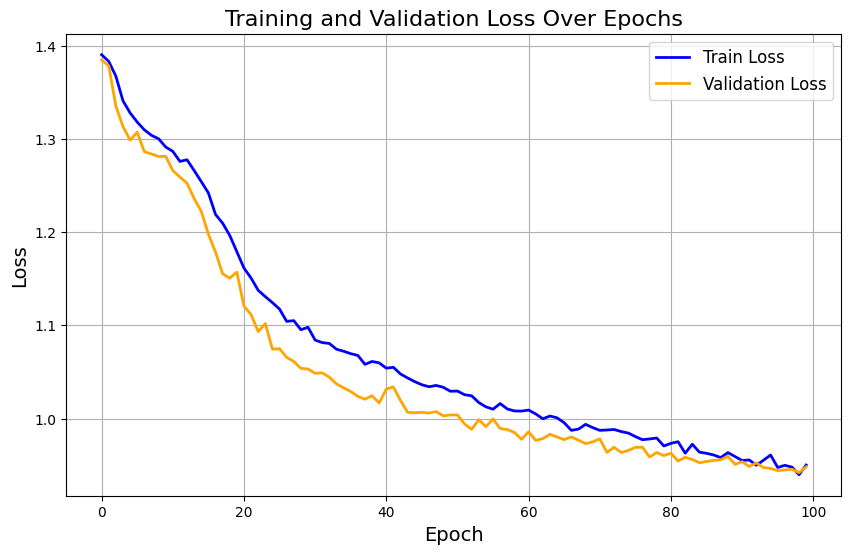

In [200]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orange", linewidth=2)
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Test the model

Test Accuracy: 81.13%


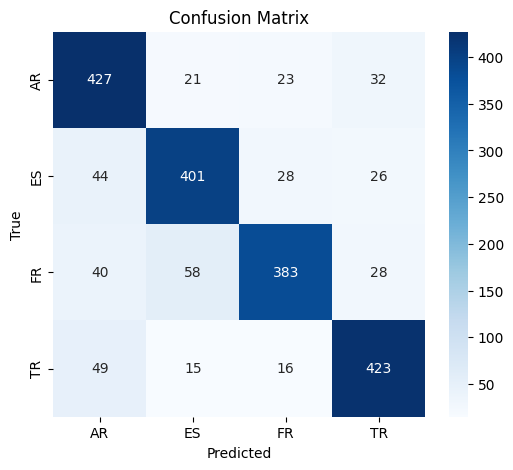

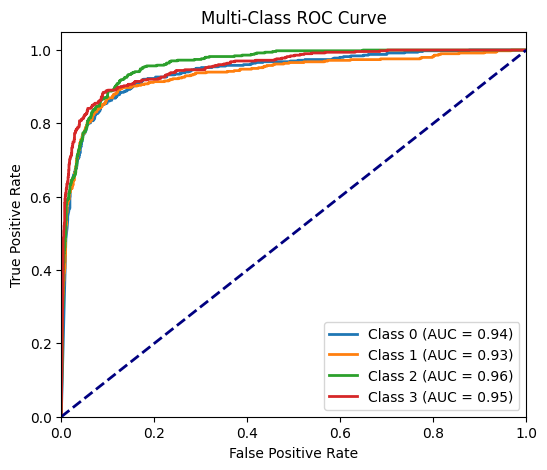

***Misclassified Examples***


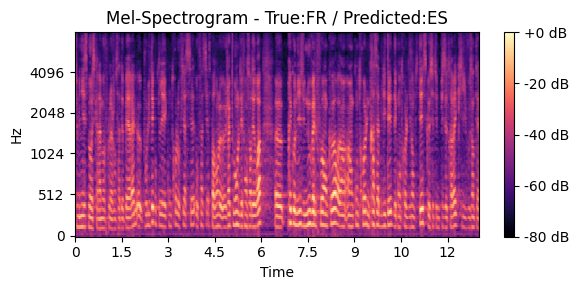

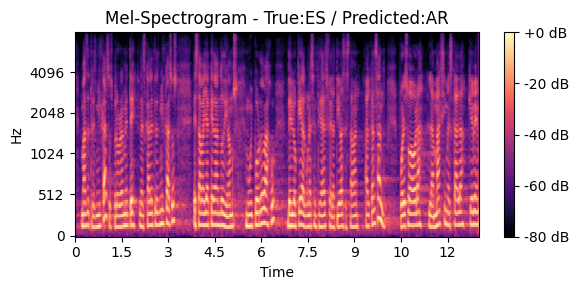

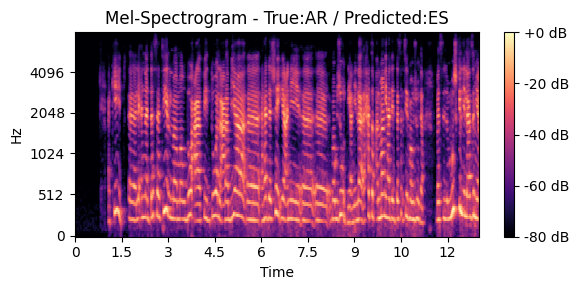

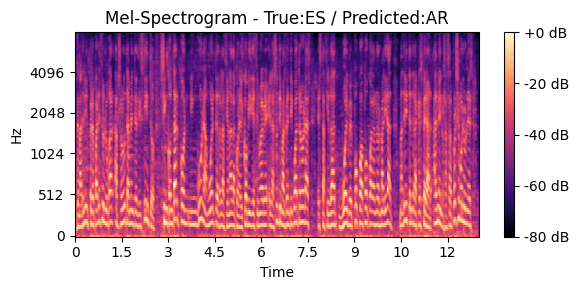

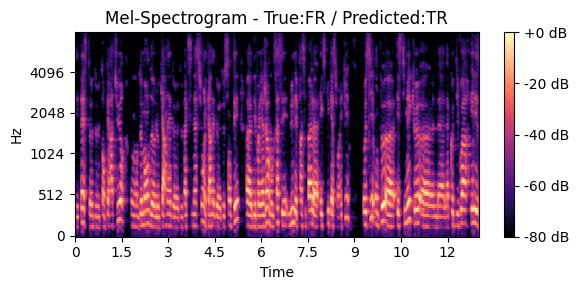

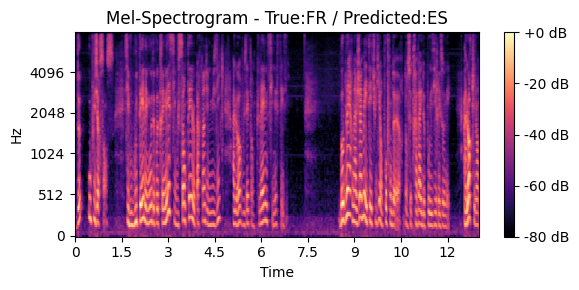

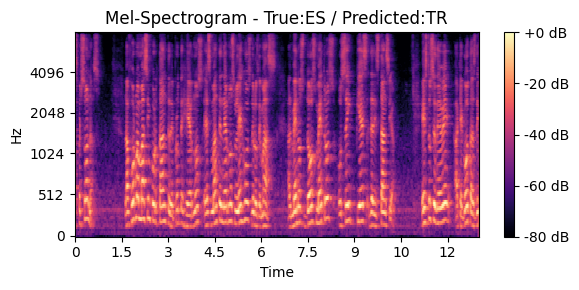

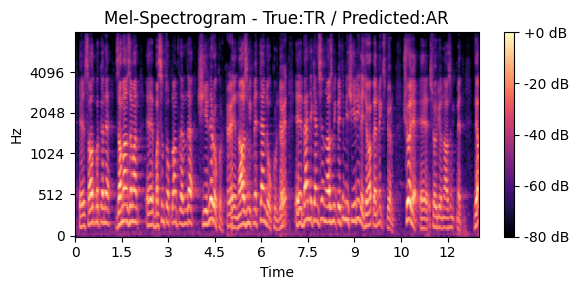

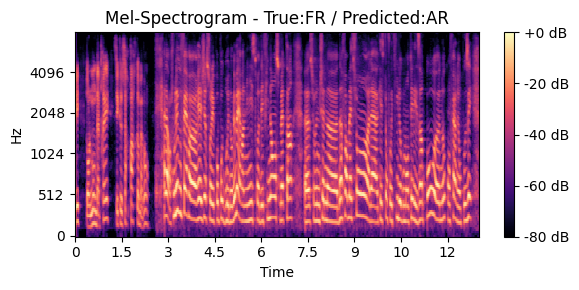

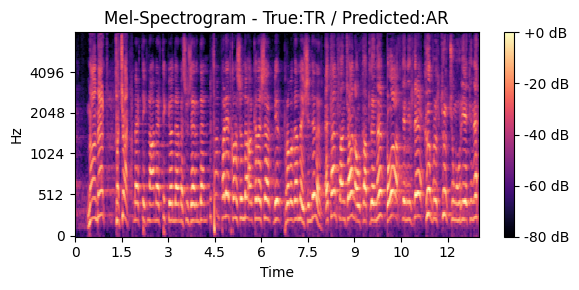

***Correctly Classified Examples***


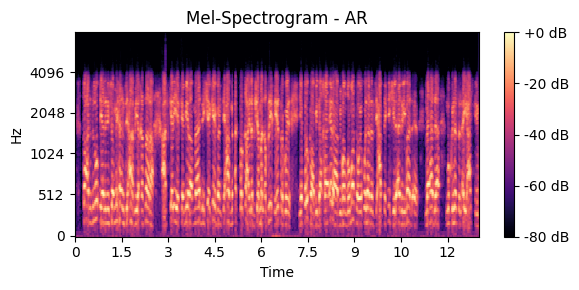

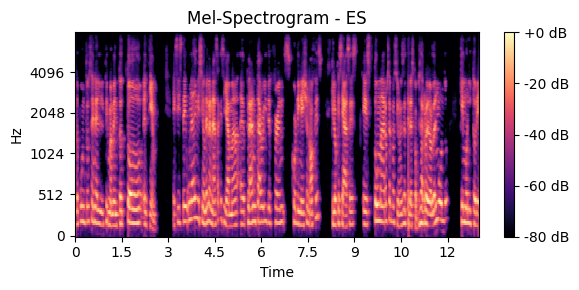

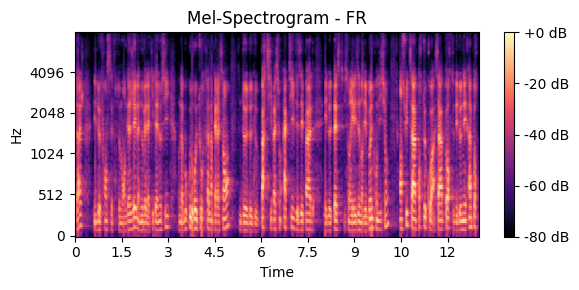

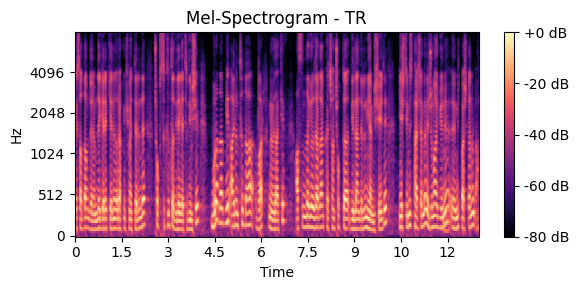

In [258]:
test_model(model,32)

### Model 2

In [202]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, padding=1)
        self.drop2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, padding=1)
        self.drop3 = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2, padding=1)
        self.drop4 = nn.Dropout2d(0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25600, 4) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.pool4(x)
        x = self.drop4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        
        return F.softmax(x, dim=1)


In [212]:
model2 = CNNModel2()
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses2, val_losses2 = train_model(model2,criterion,optimizer,100)

Epoch 1/100, Train Loss: 1.3877, Train Accuracy: 24.97%, Validation Loss: 1.3866, Validation Accuracy: 24.03%
Epoch 2/100, Train Loss: 1.3870, Train Accuracy: 24.49%, Validation Loss: 1.3866, Validation Accuracy: 24.33%
Epoch 3/100, Train Loss: 1.3866, Train Accuracy: 24.82%, Validation Loss: 1.3866, Validation Accuracy: 24.03%
Epoch 4/100, Train Loss: 1.3867, Train Accuracy: 25.08%, Validation Loss: 1.3866, Validation Accuracy: 24.18%
Epoch 5/100, Train Loss: 1.3880, Train Accuracy: 24.14%, Validation Loss: 1.3866, Validation Accuracy: 24.23%
Epoch 6/100, Train Loss: 1.3867, Train Accuracy: 25.25%, Validation Loss: 1.3866, Validation Accuracy: 24.23%
Early stopping at epoch 6. No improvement in validation loss for 5 epochs.


When the number of fully connected layers was reduced from 2 to 1, the model was unable to learn from the data.